<a href="https://colab.research.google.com/github/ahsanuamal/ahsanuamal/blob/main/Spektral_Klastering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libary (numpy, matplotlib dan linear
#algebra untuk dekomposisi Eigen)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import time
from scipy import linalg as LA
import itertools

In [4]:
# baca dataset dari file
datasetPath = "/tmp/klasering_dataset.txt"
dataset = np.loadtxt(datasetPath, delimiter=" ")

In [5]:
# mengecek apakah file tersebut ada
!ls '/tmp/klasering_dataset.txt'

/tmp/klasering_dataset.txt


In [7]:
#mendefinisikan parameter spectral klastering
k = 2 #jumlah klaster yang diinginkan
iterationCounter = 0 #counter untuk iterasi
input = dataset #input dataset
var = 2.0 #varians di RFB kernel
initCentroidMethod = "random"
print("starting...")
oldTime = np.around(time.time(), decimals=0)

starting...


In [8]:
#fungsi mendefinisikan centroid secara random
def initCentroid(dataIn, method, k):
    if (method=="random"):
        result = dataIn[np.random.choice(dataIn.shape[0],
                                         k, replace=False)]
    return result

In [9]:
#fungsi dari Gaussian similarity / RBF kernel
def RbfKernel(data1, data2, sigma):
    delta =np.matrix(abs(np.subtract(data1, data2)))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result

In [11]:
#fungsi untuk plot hasil klaster
def plotClusterResult(listClusterMembers,centroid,iteration,converged):
    n = listClusterMembers.__len__()
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    plt.figure("result")
    plt.clf()
    plt.title("iteration-" + iteration)
    marker = itertools.cycle(('.', '*', '^', 'x', '+'))
    for i in range(n):
        col = next(color)
        memberCluster = np.asmatrix(listClusterMembers[i])
        plt.scatter(np.ravel(memberCluster[:, 0]),
                    np.ravel(memberCluster[:, 1]),
                    marker=marker.__next__(), s=100,
                    c=col, label="klaster-"+str(i+1))
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    if (converged == 0):
        plt.legend()
        plt.ion()
        plt.show()
        plt.pause(0.1)
    if (converged == 1):
        plt.legend()
        plt.show(block=True)    

In [12]:
#fungsi untuk membuat matriks similarity dg fully connected graphs
def buildSimmilarityMatrix(dataIn):
    nData = dataIn.shape[0]
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))
    for i in range(0,nData):
        for j in range(0, nData):
            weight = RbfKernel(dataIn[i, :], dataIn[j, :], var)
            result[i,j] = weight
    return result

In [13]:
#fungsi untuk membuat degree matriks
def buildDegreeMatrix(similarityMatrix):
    diag = np.array(similarityMatrix.sum(axis=1)).ravel()
    result = np.diag(diag)
    return result

In [15]:
#fungsi untuk menghitung matriks Laplacian graphs
def unnormalizedLaplacian(simMatrix, degMatrix):
    result = degMatrix - simMatrix
    return result

In [16]:
#transformasi dara input ke Eige Space / data spektral
def transformToSpectral(laplacian):
    global k
    e_vals, e_vecs = LA.eig(np.matrix(laplacian))
    #ambil indeks dari k-eigen value plg kecil
    ind = e_vals.real.argsort()[:k]
    result = np.ndarray(shape=(laplacian.shape[0],0))
    #ambil eigen vector yg eigen valuenya k-paling kecil.
    #plg kecil (indek = 0 tdk diambil krn eigen value = 0)
    #jadi mulai for loop dari 1
    for i in range(1, ind.shape[0]):
        cor_e_vec = np.transpose(np.matrix(
            e_vecs[:,np.asscalar(ind[i])]))
        result = np.concatenate((result, cor_e_vec), axis=1)
    return result

In [17]:
#panggil fungsi-fungsi terkait sampai kita dapat
#data transformasi ke Eigen space
simMat = buildSimmilarityMatrix(input)
degMat = buildDegreeMatrix(simMat)
lapMat = unnormalizedLaplacian(simMat, degMat)
transformedData = transformToSpectral(lapMat)
newTime = np.around(time.time(), decimals=0)
print("time needed until eigen decomposition: ", newTime-oldTime, " s")

time needed until eigen decomposition:  343.0  s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  del sys.path[0]


In [30]:
#lakukan k-means klasering berdasarkan data yg
#sudah tertransformasi ke Eigen space
def kMeans(dataOri, transformedData, centroidInitTransf):
    nCluster = centroidInitTransf.shape[0]
    global iterationCounter, k
    # looping sampe konvergen
    while(True):
        iterationCounter +=1
        euclideanMatrixAllCluster = np.ndarray(
            shape=(transformedData.shape[0], 0))
        #loop untuk semua klaster
        for i in range(0, nCluster):
            centroidRepeated = np.repeat(centroidInitTransf[i, :],
                                         transformedData.shape[0], axis=0)
            deltaMatrix = abs(np.subtract(transformedData,
                                          centroidRepeated))
            #hitung jarak Euclidean
            euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
            euclideanMatrixAllCluster = np.concatenate((
                euclideanMatrixAllCluster, euclideanMatrix), axis=1)
        #ambil indeks matriks yang jarak Euclideannya paling kecil
        clusterMatrix = np.ravel(np.argmin(np.matrix(
            euclideanMatrixAllCluster), axis=1))
        listClusterMemberTransf = [[] for i in range(k)]
        listClusterMemberOri = [[] for i in range(k)]
        #tepatkan obyek data ke klaster yg jarak Euclideannya plg kecil
        for i in range(0, transformedData.shape[0]):
            listClusterMemberTransf[np.asscalar(clusterMatrix[i])].append(
                np.array(transformedData[i, :]).ravel())
            listClusterMemberOri[np.asscalar(clusterMatrix[i])].append(
                np.array(dataOri[i, :]).ravel())
        #hitung titik pusat klaster yang baru
        newCentroidTransf = np.ndarray(shape=(0,
                                              centroidInitTransf.shape[1]))
        newCentroidOri = np.ndarray(shape=(0, dataOri.shape[1]))
        print("iteration: ", iterationCounter)
        for i in range(0,nCluster):
            memberClusterTransf = np.asmatrix(listClusterMemberTransf[i])
            memberClusterOri = np.asmatrix(listClusterMemberOri[i])
            print("cluster members number-", i+1, ": ",
                  memberClusterTransf.shape)
            centroidClusterTransf = memberClusterTransf.mean(axis=0)
            centroidClusterOri = memberClusterOri.mean(axis=0)
            newCentroidTransf = np.concatenate((newCentroidTransf,
                                                centroidClusterTransf),
                                                axis=0)
            newCentroidOri = np.concatenate((newCentroidOri,
                                             centroidClusterOri), axis=0)
        #stop jika sudah konvergen
        if((centroidInitTransf == newCentroidTransf).all()):
            break
        # update titik pusat klaster dengan yg baru
        centroidInitTransf = newCentroidTransf
        plotClusterResult(listClusterMemberOri, newCentroidOri,
                          str(iterationCounter), 0)
        time.sleep(2) #dikasih delay untuk visualisasi saja
    return listClusterMemberOri, newCentroidOri, listClusterMemberTransf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration:  1
cluster members number- 1 :  (200, 1)
cluster members number- 2 :  (200, 1)


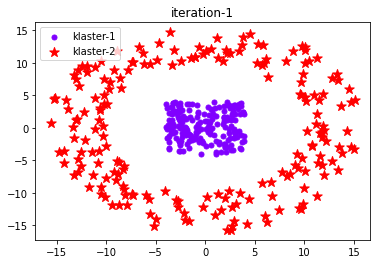

iteration:  2
cluster members number- 1 :  (200, 1)
cluster members number- 2 :  (200, 1)
converged!


Text(0.5, 1.0, 'data transformasi di Eigen Space')

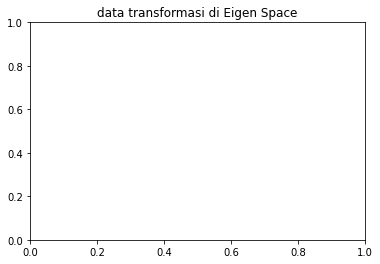

In [31]:
#panggil fungsi untuk inisialisasi titik pusat klaster
centroidInit = initCentroid(transformedData, initCentroidMethod, k)
#panggil fungsi k-means klastering
clusterMemberResult,centroid,dataInEigenSpace = kMeans(input,
                                                       transformedData,
                                                       centroidInit)
print("converged!")
plt.figure("eigen space")
plt.title("data transformasi di Eigen Space")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


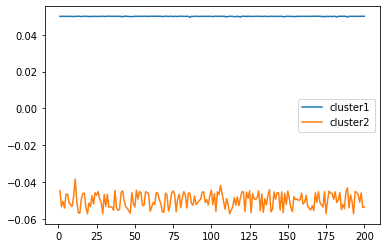

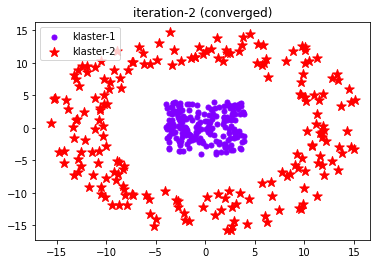

In [32]:
#plot hanya untuk visualisasi data transformasi di Eigen Space
if (k==2):
    for i in range(dataInEigenSpace.__len__()):
        memberTransf = np.asarray(dataInEigenSpace[i]).ravel()
        axis = np.linspace(1, dataInEigenSpace[i].__len__(),
                           dataInEigenSpace[i].__len__())
        plt.plot(axis, memberTransf, label= 'cluster'+str(i+1))
    plt.legend(loc='center right')
if (k==3):
    for i in range(dataInEigenSpace.__len__()):
        memberTransf = np.asarray(dataInEigenSpace[i])
        plt.scatter(np.ravel(memberTransf[:,0]), np.ravel(
            memberTransf[:,1]), label= 'cluster'+str(i+1))
    plt.legend(loc='upper left')
#plot hasil final setelah konvergen
plotClusterResult(clusterMemberResult, centroid,
                  str(iterationCounter) + " (converged)", 1)